# Identifying Age-Related Conditions Using Machine Learning Models
## Author: Boni M. Ale, MD, MSc, MPH
### Date: 08 June 2023

# 1. Introduction

To determine if someone has these medical conditions requires a long and intrusive process to collect information from patients. With predictive models, we can shorten this process and keep patient details private by collecting key characteristics relative to the conditions, then encoding these characteristics.

In this project, I will use Machine Learning to detect conditions with measurements of anonymous characteristics. Therefore the general objective of this analysis is to predict if a person has any of three medical conditions. In order to predict if the person has one or more of any of the three medical conditions (Class 1), or none of the three medical conditions (Class 0), I will create a model trained on anonymous measurements of health characteristics.



**Load Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

**Load Datasets**

In [2]:
train_raw = pd.read_csv('/Users/boniale/Desktop/Data_Science/ML_iard/data/train.csv')
test = pd.read_csv('/Users/boniale/Desktop/Data_Science/ML_iard/data/test.csv')
greeks_raw = pd.read_csv('/Users/boniale/Desktop/Data_Science/ML_iard/data/greeks.csv')
sample_submission = pd.read_csv('/Users/boniale/Desktop/Data_Science/ML_iard/data/sample_submission.csv')

# 2. Exploratory Data Analysis

## 2.1. Data Description

### → Train Data 

In [3]:
print("Raw Train Data Set's size: ", train_raw.shape)

#separate variables into new data frames
numeric_data = train_raw.select_dtypes(include=[np.number])
cat_data = train_raw.select_dtypes(exclude=[np.number])
cat_data = cat_data.drop(['Id'], axis=1)
print ("There are {} numeric and {} categorical columns in train raw data".format(numeric_data.shape[1],cat_data.shape[1]))

Raw Train Data Set's size:  (617, 58)
Raw Greeks Data Set's size:  (617, 6)
There are 56 numeric and 1 categorical columns in train raw data


In [33]:
print(train_raw.describe())

               AB            AF           AH          AM          AR  \
count  617.000000    617.000000   617.000000  617.000000  617.000000   
mean     0.477149   3502.013221   118.624513   38.968552   10.128242   
std      0.468388   2300.322717   127.838950   69.728226   10.518877   
min      0.081187    192.593280    85.200147    3.177522    8.138688   
25%      0.252107   2197.345480    85.200147   12.270314    8.138688   
50%      0.354659   3120.318960    85.200147   20.533110    8.138688   
75%      0.559763   4361.637390   113.739540   39.139886    8.138688   
max      6.161666  28688.187660  1910.123198  630.518230  178.943634   

               AX          AY          AZ           BC           BD   ...  \
count  617.000000  617.000000  617.000000   617.000000    617.000000  ...   
mean     5.545576    0.060320   10.566447     8.053012   5350.388655  ...   
std      2.551696    0.416817    4.350645    65.166943   3021.326641  ...   
min      0.699861    0.025578    3.396778  

It seems like there is 56 numeric variables which include our target ("if the person has one or more of any of the three medical conditions (Class 1)" or "none of the three medical conditions (Class 0)"). Therefore Class is actually a binary categorical variable. 

### → Test Data

In [30]:
print("Raw Test Data Set's size: ", test.shape)

#separate variables into new data frames
numtest_data = test.select_dtypes(include=[np.number])
cattest_data = test.select_dtypes(exclude=[np.number])
cattest_data = cattest_data.drop(['Id'], axis=1)
print ("There are {} numeric and {} categorical columns in test raw data".format(numtest_data.shape[1],cattest_data.shape[1]))

Raw Test Data Set's size:  (5, 57)
There are 56 numeric and 0 categorical columns in test raw data


In [32]:
print(test.describe())

        AB   AF   AH   AM   AR   AX   AY   AZ   BC  BD   ...   FI   FL   FR  \
count  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  ...  5.0  5.0  5.0   
mean   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
std    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
min    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
25%    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
50%    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
75%    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
max    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

        FS   GB   GE   GF   GH   GI   GL  
count  5.0  5.0  5.0  5.0  5.0  5.0  5.0  
mean   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
std    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
min    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
25%    0.0  0.0  0.0  0.0  0.0  0.0  0.0  
50%    0.0  0.0  0.0  0.0  0.0

In the test dataset all values are the same apart from the Id.  

### → Greek Data

In [37]:
print("Raw Greek Data Set's size: ", greeks_raw.shape)

#separate variables into new data frames
numgreeks_data = greeks_raw.select_dtypes(include=[np.number])
catgreeks_data = greeks_raw.select_dtypes(exclude=[np.number])
catgreeks_data = catgreeks_data.drop(['Id'], axis=1)
print ("There are {} numeric and {} categorical columns in test raw data".format(numgreeks_data.shape[1],catgreeks_data.shape[1]))

Raw Greek Data Set's size:  (617, 6)
There are 0 numeric and 5 categorical columns in test raw data


In [36]:
print(greeks_raw.describe())

                  Id Alpha Beta Gamma Delta  Epsilon
count            617   617  617   617   617      617
unique           617     4    3     8     4      198
top     000ff2bfdfe9     A    C     M     B  Unknown
freq               1   509  407   445   456      144


## 2.2. Numerical Variables Exploration

Let's work on numeriacal features.

In [4]:
Target = ['Class']
allFeature = train_raw.columns.tolist()
included_features = [feature for feature in allFeature if feature not in Target]

numericalFeatures = train_raw[included_features].select_dtypes(include=['number'])

In [5]:
numericalFeatures

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,9.879296,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000
613,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.910227,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340
614,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,12.029366,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000
615,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,4517.86560,...,8.026928,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622


There is actually 55 numeric variables.

Let's explore the overall distribution of these variables.

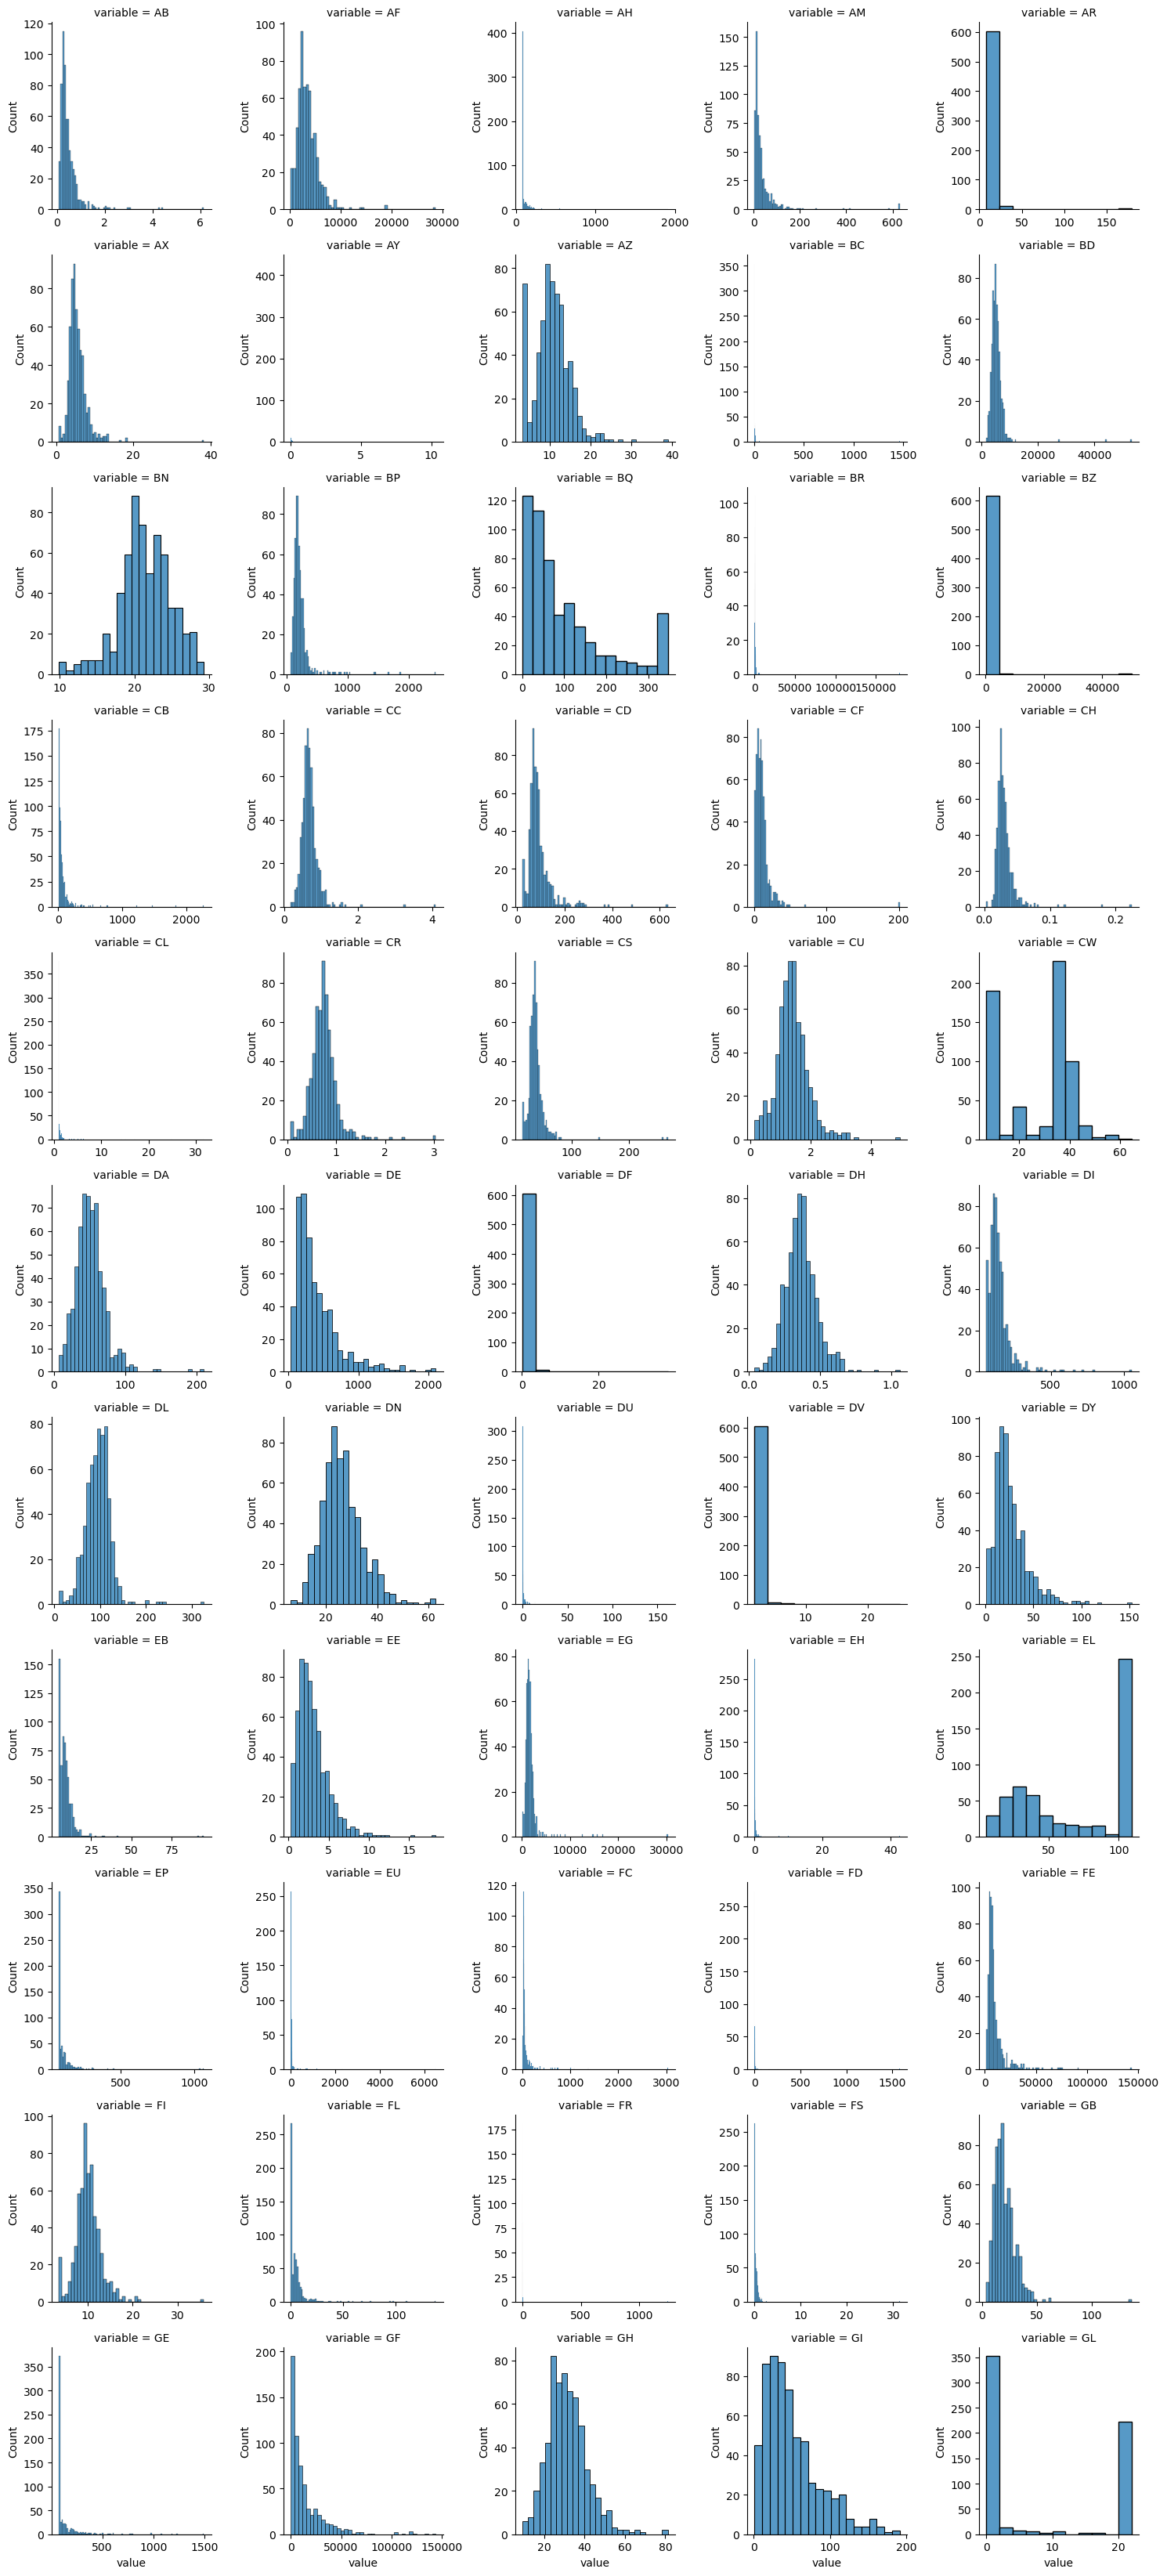

In [6]:
num = [f for f in train_raw.columns if train_raw.dtypes[f] != 'object']
num.remove("Class")
nd = pd.melt(train_raw, value_vars = num)
barplot_train = sns.FacetGrid (nd, col='variable',
                    col_wrap=5, 
                    sharex=False, 
                              sharey = False
                   )
barplot_train = barplot_train.map(sns.histplot, 'value')
plt.show("barplot_train")

We can see that several variables are not normally distributed.

The distribution of the data confirmed the imbalance distribution of features among those who have the diseases and those who doesn't.

Are these variables highly correlated among each other ? Let's explore this visually with a heatmap. 

In [7]:
# Define Display a correlation heatmap Function
def display_correlation_heatmap(df, title):
    corr_mat = np.round(df.corr(), 3)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(corr_mat, annot=True, fmt=".3f", cmap='coolwarm', cbar=False, square=True, linewidths=.5, annot_kws={"size": 12}, ax=ax)

    ax.set_title(title, fontsize=16, pad=20, y=1.05)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)

    plt.tight_layout()
    plt.show()
       
def plot_correlation_heatmap(df, column_name):
    correlation_matrix = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation heatmap for {column_name}')
    plt.show()

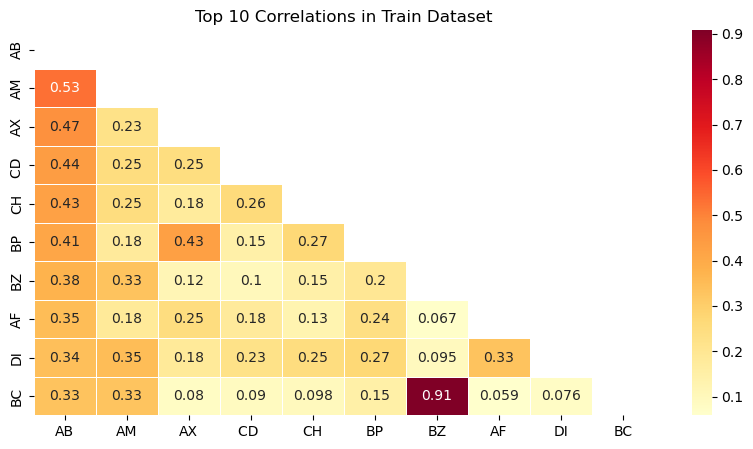

In [8]:
# Display a correlation heatmap
def plot_top_correlations(df: pd.core.frame.DataFrame, n: int, title_name: str='Top Correlations') -> None:
    # Calculate correlation between all variables
    corr = df.corr()

    # Select variables having highest absolute correlation
    top_corr_cols = corr.abs().nlargest(n, columns=corr.columns).index
    top_corr = corr.loc[top_corr_cols, top_corr_cols]

    fig, axes = plt.subplots(figsize=(10, 5))
    mask = np.zeros_like(top_corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(top_corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

# Plot heatmap of top 12 correlations in training data
plot_top_correlations(numericalFeatures, 10, 'Top 10 Correlations in Train Dataset')

We can see that some variables are correlate but not highly correlated in general apart from variable BZ and BC which are highly correlated.

## 2.3. Target Distribution

First, let's first calculate the frequency table for those have one or more of any of the three medical conditions (Class 1), or none of the three medical conditions (Class 0). Secondly, we will generate the percentages in each group. Finaly, I will do a visualisation to show the distribution of our target.

#### *Frequency Table of Class*

In [9]:
freq_tab = pd.crosstab(index = train_raw["Class"],  # Make a crosstab
                     columns="Total")                  # Name the count column
freq_tab

col_0,Total
Class,
0,509
1,108


#### *Percentage Table of Class*

In [10]:
my_tab = pd.crosstab(index = train_raw["Class"],  # Make a crosstab
                     columns="Percentage")                  # Name the count column

my_tab/my_tab.sum()*100 # Calculate the percentages 

col_0,Percentage
Class,
0,82.495948
1,17.504052


#### *Visualisation of Class*

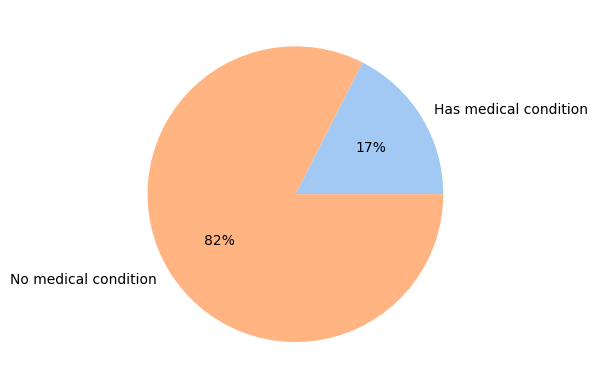

In [11]:
#define data
data_targ = [17.5 , 82.5]
labels = ['Has medical condition', 'No medical condition']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:50]

#create pie chart
plt.pie(data_targ, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In the train dataset only 18% subjects have been diagnosed with one the three conditions.

This look like an imbalance data as the number of people who has one or more of any of the three medical conditions is quite smaller than people with none of the three medical conditions.

## 2.4. Relationship between Target and Features

Let's see the distribution of our features among people who has one or more of any of the three medical conditions and  those with none of the three medical conditions.

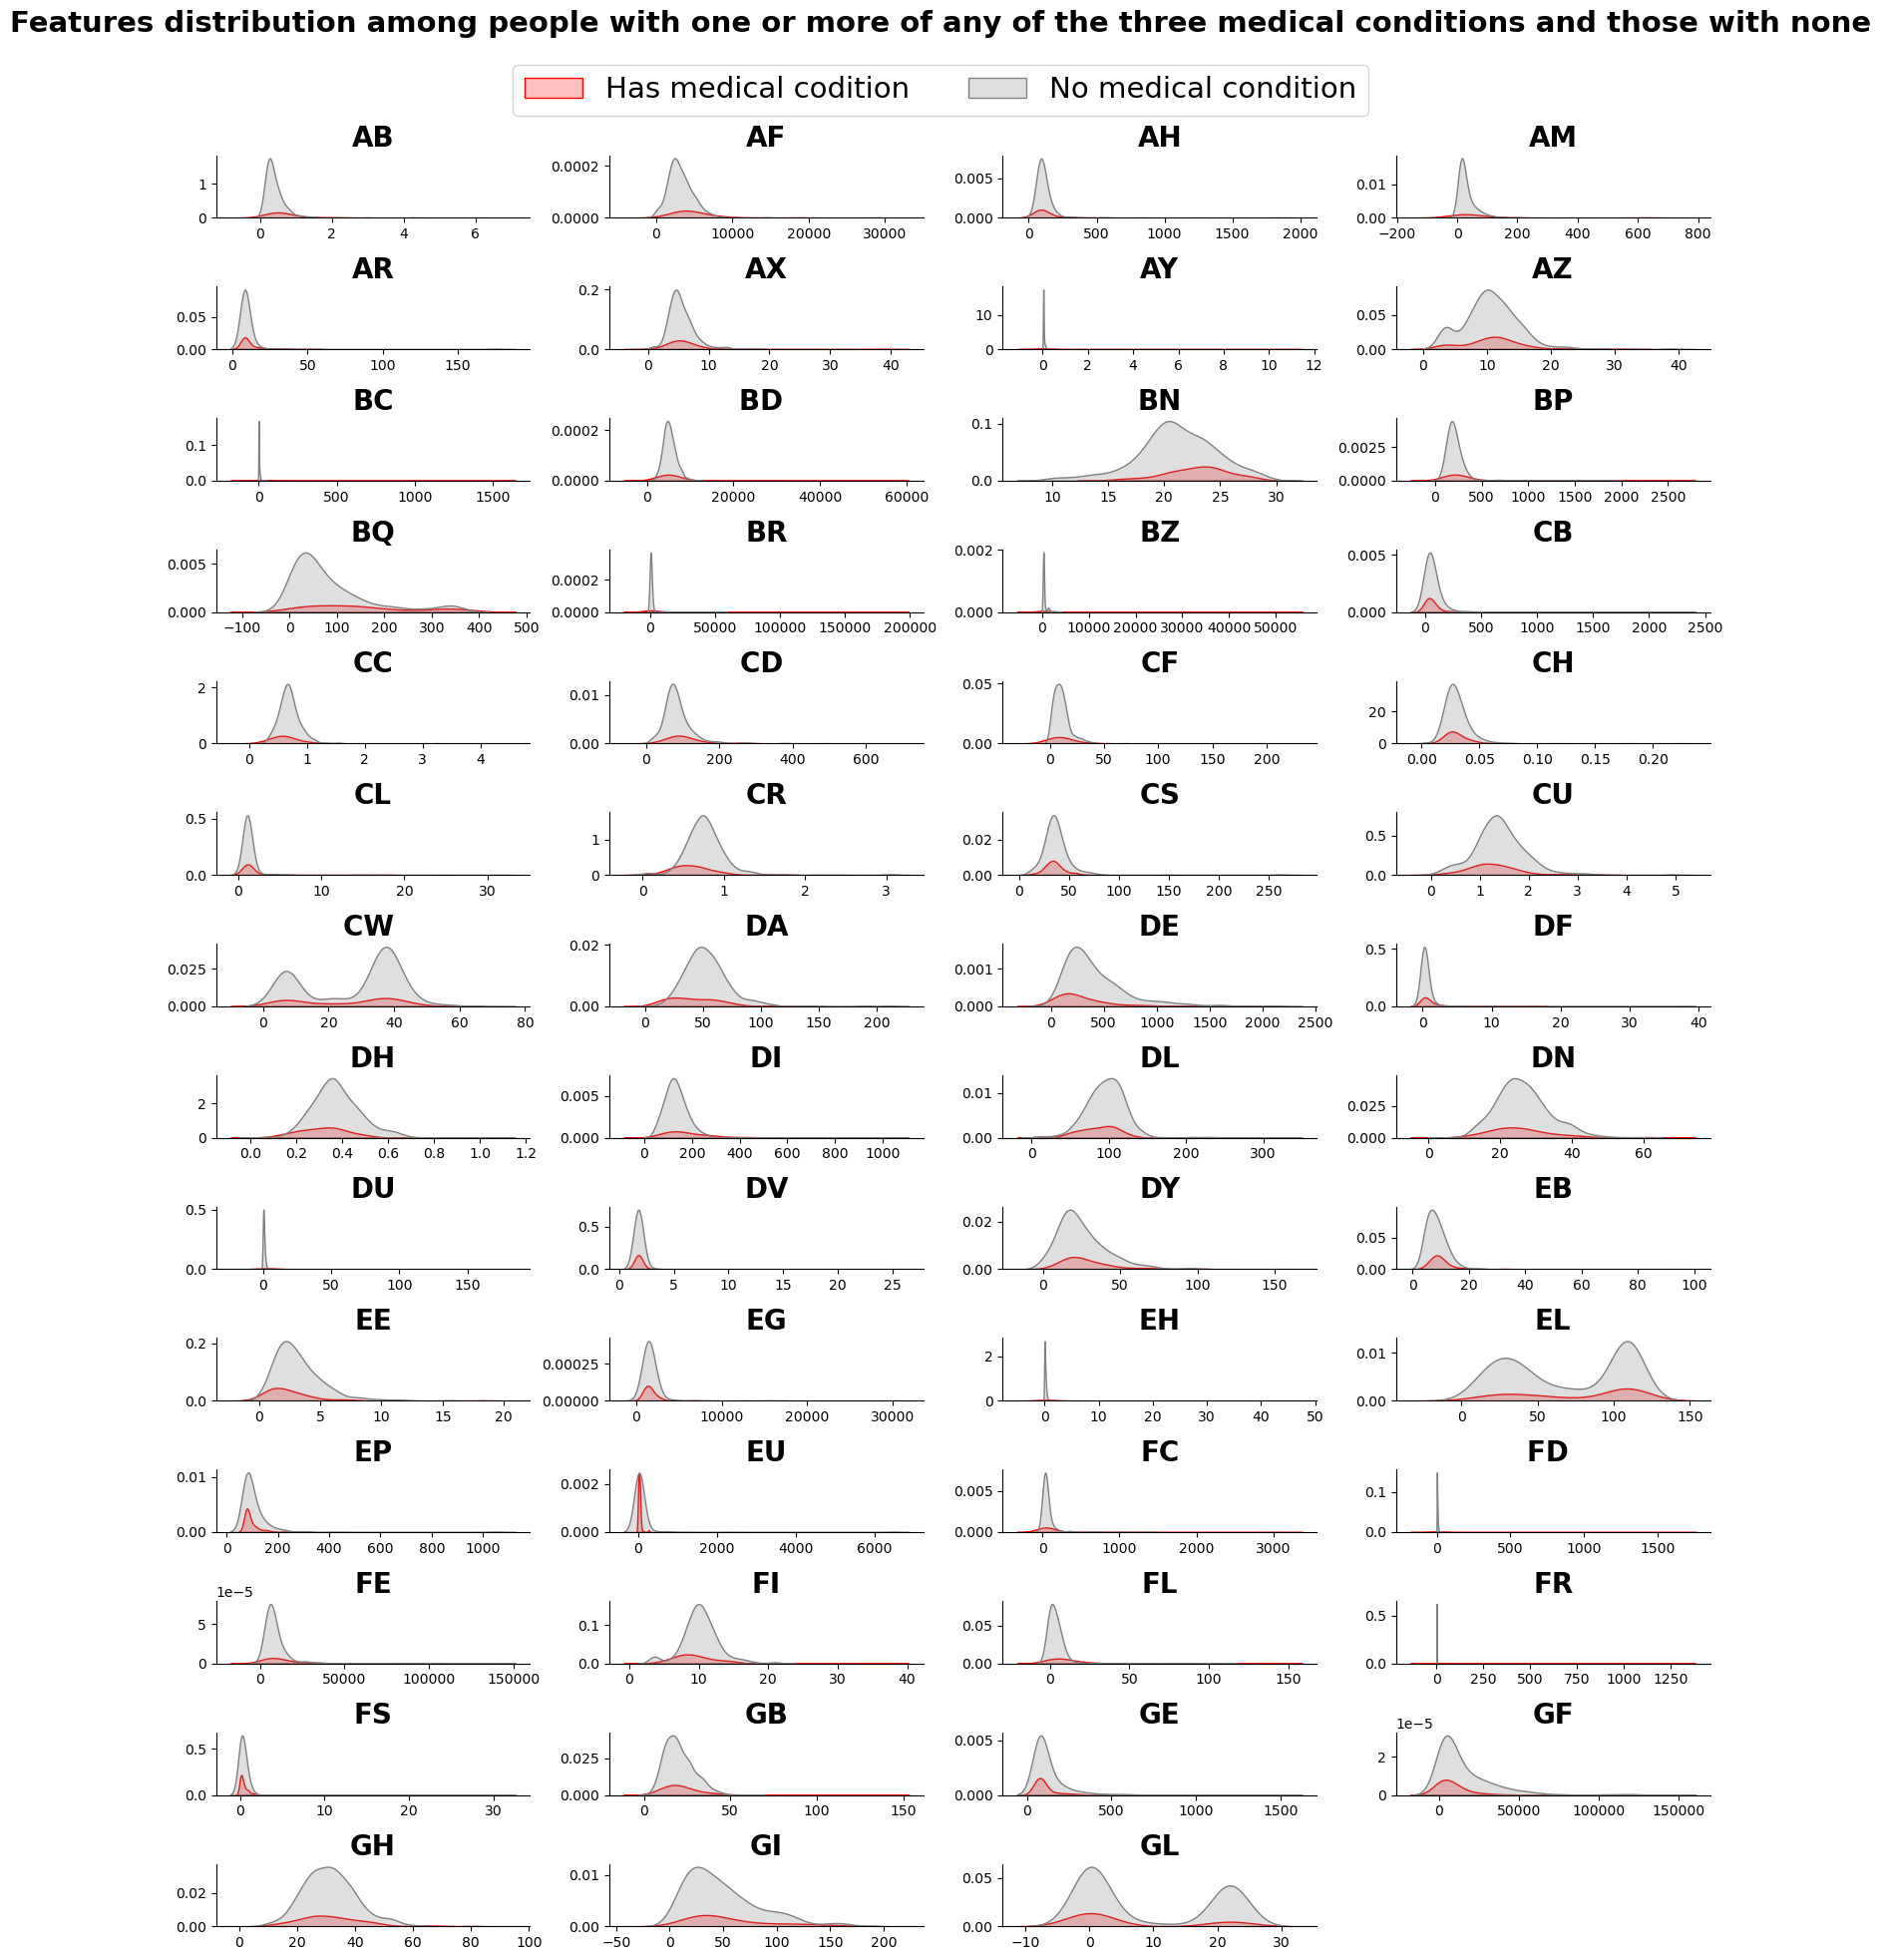

In [12]:
figsize = (4*4, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(numericalFeatures):
    ax = plt.subplot(14,4, idx + 1)
    sns.kdeplot(
        hue='Class',
        data=train_raw, fill=True,
        x=col, palette=["Gray", "Red"], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='center', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features distribution among people with one or more of any of the three medical conditions and those with none\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend(['Has medical codition', 'No medical condition'], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

The distribution of the data confirmed the imbalance distribution of our features and target.

## 2.5. Data Wrangling

### 2.5.1. Missing Data

#### 2.5.1.1. Missing data exploration

Let's identify any missing value. Depending on the extend, we will decide on droping the variable or imput the data based on the missingness mecanism.

In [13]:
mis_data_count = train_raw.isnull().sum()
mis_data_percent = train_raw.isnull().sum() / len(train_raw) * 100

missing_dataframe = pd.DataFrame({
    'Count': mis_data_count,
    'Percent': mis_data_percent
})



missing_dataframe = missing_dataframe[missing_dataframe.Count > 0]
missing_dataframe.sort_values(by='Count', ascending=False, inplace=True)

print(f"There are {missing_dataframe.shape[0]} features having missing data.\n")
print("Top 10 missing value features:")
missing_dataframe.head(10)

There are 9 features having missing data.

Top 10 missing value features:


,Count,Percent
BQ,60,9.724473
EL,60,9.724473
CC,3,0.486224
CB,2,0.324149
FS,2,0.324149
DU,1,0.162075
FC,1,0.162075
FL,1,0.162075
GL,1,0.162075


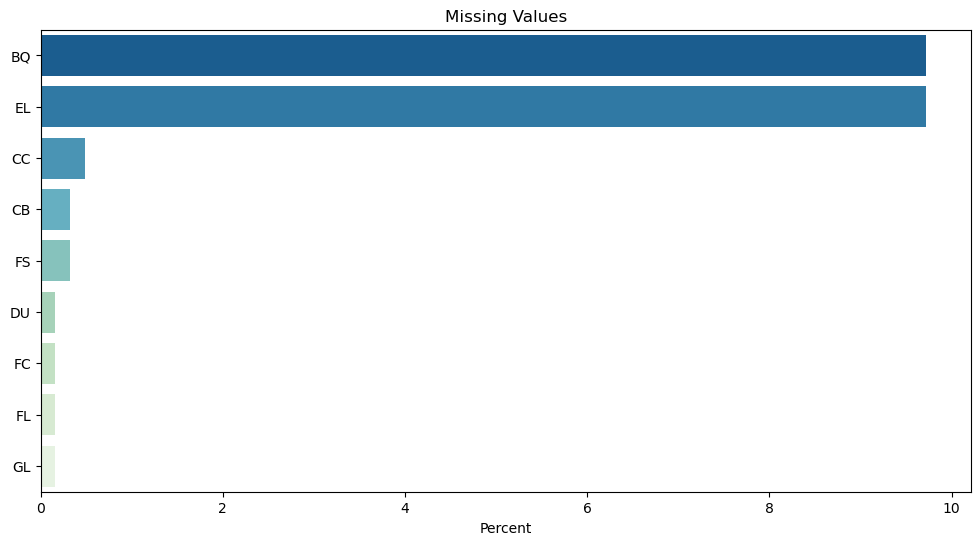

In [14]:
plt.figure(figsize=(12, 6))
sns.barplot(y=missing_dataframe.index,
            x=missing_dataframe.Percent,
            palette='GnBu_r')
title = plt.title("Missing Values")
plt.show()

#### 2.5.1.2. Missing Data Imputation

Giving that all these variables missing variables are numeric variables, I will impute them with their medians because 
the distribution of these data values are skewed. 

In [15]:
specific_vars = [
    'BQ', 'EL', 'CC', 'CB', 'FS', 'DU', 'FC', 'FL', 'GL'
]

imputer = SimpleImputer(missing_values=np.NaN, strategy='median')

train_raw[specific_vars] = pd.DataFrame(imputer.fit_transform(train_raw[specific_vars]), index=train_raw.index)

Now, let's verify if there are still missing data in our dataset. 

In [16]:
sum(train_raw.isnull().sum())

0

⎆ There is now no missing data in our train data. 

### 2.5.2. Data Spliting and Scaling

In [17]:
# convert categorical data in numerical for categorical column
train_raw['EJ'] = train_raw['EJ'].replace({'A': 0, 'B': 1})
test['EJ'] = test['EJ'].replace({'A': 0, 'B': 1})

In [18]:
test

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# data spliting
X_train = train_raw.drop(['Id','Class'], axis=True)
y_train = train_raw['Class']

X_test = test.drop('Id', axis=True)

In [ ]:
# data standarization 
sc=StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train))

In [ ]:
X_train_scaled

### 2.5.3. Data Balancing

In [ ]:
oversample = RandomOverSampler(random_state=0)
X_train_balanced, y_train = oversample.fit_resample(X_train_scaled, y_train)
# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
print("X_train.shape:", X_train.shape)
print("X_train_scaled.shape:", X_train_scaled.shape)
print("X_train_balanced.shape:", X_train_balanced.shape)
print("y_train.shape:", y_train.shape)

In [ ]:
pd.DataFrame(X_train_balanced)

# 3. Data Modelling

## 3.1. Logistic Regression

In [ ]:
iard_mod = LogisticRegression(random_state=0)
iard_mod.fit(X_train_balanced, y_train)

In [ ]:
# LogisticRegression
iard_mod = LogisticRegression(random_state=0)
iard_mod.fit(X_train_balanced, y_train)

In [ ]:
y_pred2 = iard_mod.predict(X_test)

In [ ]:
# Prediction
y_pred = iard_mod.fit(X_train_balanced, y_train.values)
y_pred = pd.DataFrame(iard_mod.predict(X_test))
y_pred.head(10)

In [ ]:
acc = accuracy_score(y_train, y_pred)
print("Logistic Regression model accuracy (in %):", acc*100)

In [ ]:

y_pred = iard_mod1.predict(X_test)
y_pred

In [ ]:
acc = accuracy_score(y, y_pred)
print("Logistic Regression model accuracy (in %):", acc*100)

## 3.2. 